# Light GBM

Use tree-based algorithms since they are powerful and do not impose strict assumptions on features like linearity or independence. Light GBM is a fast algorithm with lower memory usage.

In [1]:
#!pip install lightgbm

In [2]:
#conda install numpy

Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime  import datetime  
from datetime import timedelta  
import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.lightgbm

Read data

In [2]:
X_train = pd.read_pickle('../01_preprocessed_data/X_train.pkl')
y_train = pd.read_pickle('../01_preprocessed_data/y_train.pkl')
X_val = pd.read_pickle('../01_preprocessed_data/X_val.pkl')
y_val = pd.read_pickle('../01_preprocessed_data/y_val.pkl')
X_test = pd.read_pickle('../01_preprocessed_data/X_test.pkl')

In [3]:
data_location = '../00_data/sample_submission.csv'
submission = pd.read_csv(data_location)

Set parameters of the light GBM and select features to fit.

In [4]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)

(44107087, 44)
(853720, 44)
(853720, 44)
(44107087, 1)
(853720, 1)


In [50]:
params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective':  'poisson',
        'n_jobs': -1,
        'seed': 0,
        'learning_rate': 0.1, 
        'bagging_fraction': 0.75,
        'bagging_freq': 10, 
        'colsample_bytree': 0.75, 
        'num_iterations':2000}
not_features = ['d', 'id', 'demand', 'date', 'start_date']

In [6]:
param_grid = {'boosting_type': ['gbdt'],
        'metric': ['rmse'],
        'objective': ['poisson', 'tweedie'],
        'n_jobs': [-1],
        'seed': [0],
        'learning_rate':  [0.05, 0.075, 0.1],
        'bagging_fraction': [0.5, 0.75, 1],
        'bagging_freq': [10], 
        'colsample_bytree': [0.75],
        'num_iterations': [1000, 5000],
        'early_stopping_round': [500]}

In [7]:
features = X_test.columns[~X_test.columns.isin(not_features)]

In [8]:
X_train['date'].head()

428807   2011-03-05
428808   2011-03-05
428809   2011-03-05
428810   2011-03-05
428811   2011-03-05
Name: date, dtype: datetime64[ns]

In [12]:
X_train = X_train[X_train['date'] >= "2014-01-01"]
y_train = X_train['demand']


In [13]:
train_set = lgb.Dataset(X_train[features], y_train) #, categorical_feature = categorical_features)
val_set = lgb.Dataset(X_val[features], y_val)#,  categorical_feature = categorical_features)

Train the model

In [ ]:
model = lgb.train(params, train_set,  
                  valid_sets = [train_set, val_set], verbose_eval = 100)

C:\Users\omore\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's rmse: 2.3677	valid_1's rmse: 2.24204
[200]	training's rmse: 2.30043	valid_1's rmse: 2.1933
[300]	training's rmse: 2.26129	valid_1's rmse: 2.16385
[400]	training's rmse: 2.23646	valid_1's rmse: 2.1614
[500]	training's rmse: 2.21589	valid_1's rmse: 2.16056
[600]	training's rmse: 2.19961	valid_1's rmse: 2.15727
[700]	training's rmse: 2.18651	valid_1's rmse: 2.15861
[800]	training's rmse: 2.1741	valid_1's rmse: 2.1597
[900]	training's rmse: 2.16391	valid_1's rmse: 2.16576
[1000]	training's rmse: 2.15409	valid_1's rmse: 2.16814
[1100]	training's rmse: 2.14552	valid_1's rmse: 2.16683
[1200]	training's rmse: 2.13501	valid_1's rmse: 2.17179
[1300]	training's rmse: 2.1272	valid_1's rmse: 2.17077
[1400]	training's rmse: 2.12026	valid_1's rmse: 2.18117
[1500]	training's rmse: 2.11445	valid_1's rmse: 2.18098
[1600]	training's rmse: 2.10876	valid_1's rmse: 2.18049
[1700]	training's rmse: 2.10292	valid_1's rmse: 2.18094


In [ ]:
i = 0
for g in ParameterGrid(param_grid):
    print(i)
    print(g)
    mlflow.lightgbm.autolog() 
    model = lgb.train(g, train_set,  
                  valid_sets = [train_set, val_set], verbose_eval = 100)
    
    y_test = model.predict(X_test[features])
    X_test['demand'] = y_test

    predictions = X_test[['id', 'days_from_start', 'demand']]
    predictions = pd.pivot(predictions, index = 'id', columns = 'days_from_start', values = 'demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on = 'id')
    final = pd.concat([validation, evaluation])
    final.head()
    final.to_csv('../04_submissions/lightGBM_{}.csv'.format(i), index = False)
    i = i + 1
    print("------------------------------------")

In [11]:
print(len(ParameterGrid(param_grid)))

18


Calculate the RMSE on the validation set

In [15]:
y_test = model.predict(X_test[features])

In [43]:
val_pred = model.predict(X_val[features])
val_score = np.sqrt(metrics.mean_squared_error(val_pred, y_val))
X_val['demand'] =  np.asarray(y_val.loc[:, 'demand'])#y_val
X_val['demand_pred'] = val_pred
X_val['abs_difference'] = abs(X_val['demand'] - X_val['demand_pred'])
print(f'Our val rmse score is {val_score}')
y_test = model.predict(X_test[features])
X_test['demand'] = y_test


Our val rmse score is 2.2420387368491523


In [44]:
print(f'Our val mae score is {metrics.mean_absolute_error(val_pred, y_val)}')

Our val mae score is 1.0613873192157368


We look at the mean absolute error by forecastablity in order to indestand what category needs more improvement for prediction.

In [45]:
X_val.groupby(['demand_type'])['demand_type', 'abs_difference'].agg(['mean']).reset_index()

,demand_type,abs_difference
,,mean
0,0,0.906444
1,erratic,3.547175
2,intermittent,0.709413
3,lumpy,1.554988
4,smooth,2.817289


Text(0.5, 0, 'absolute error')

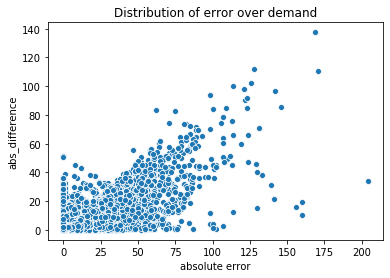

In [46]:
demans_vs_error = sns.scatterplot(x=X_val['demand'], y=X_val['abs_difference'])
demans_vs_error.set_title('Distribution of error over demand')
demans_vs_error.set_xlabel('absolute error')

Surprisingly smooth time series has a large mean absolute error. Erratic time series has a large mean absolute error; typically time series of this type is difficult to predict.

## Feature importance

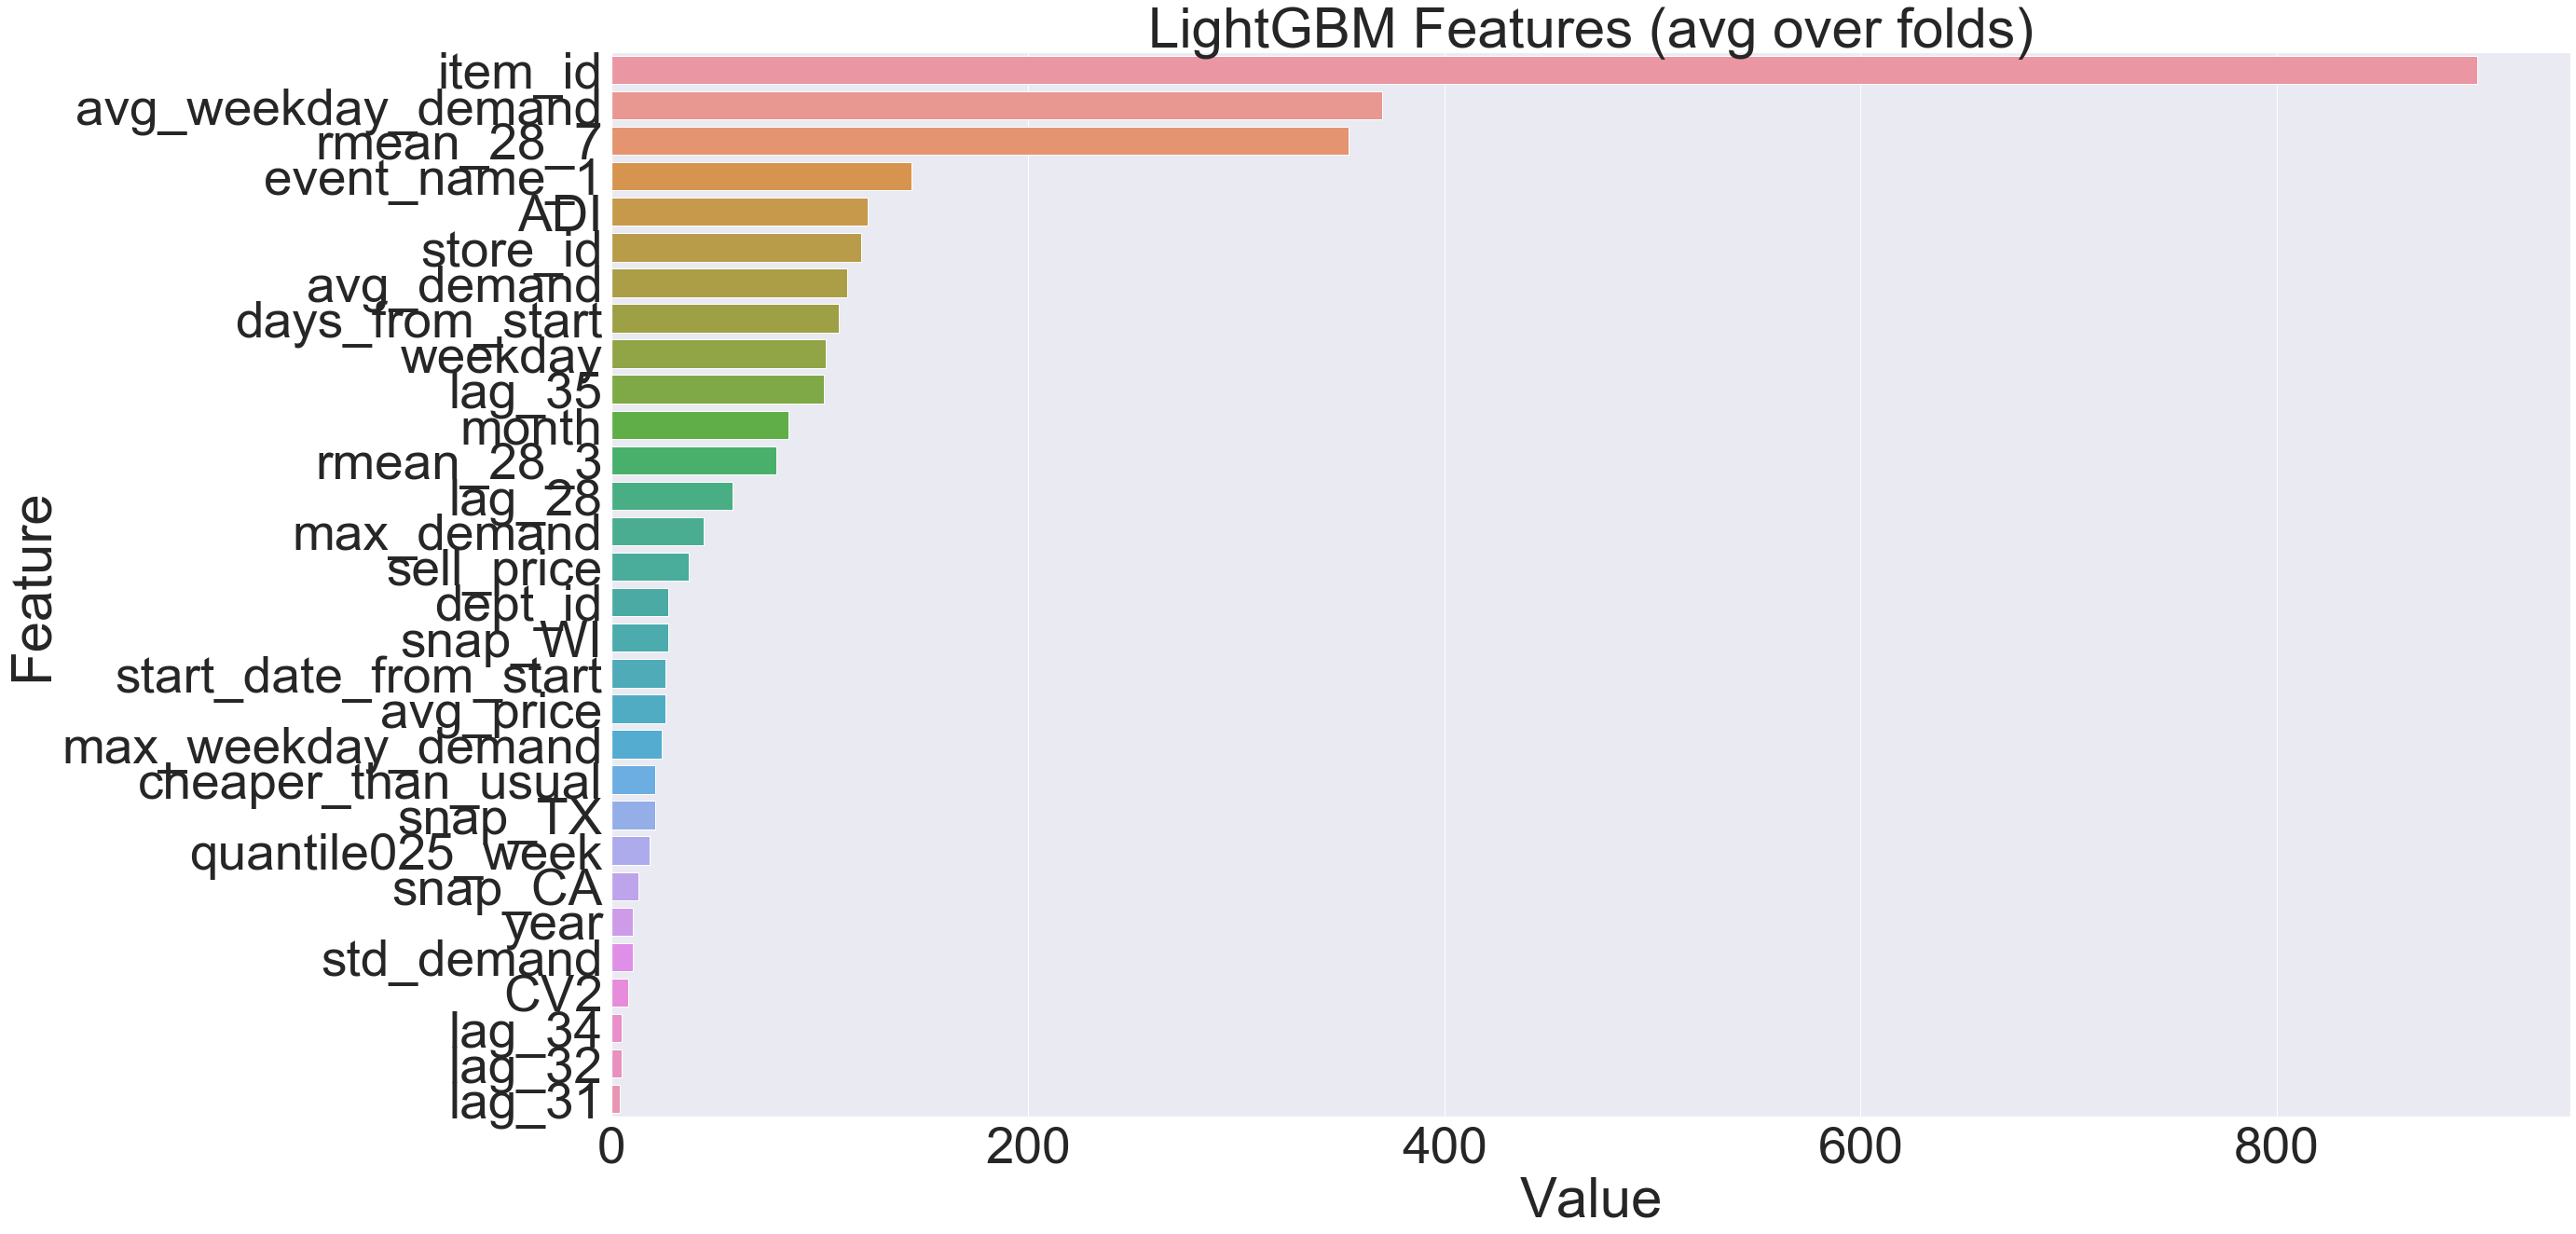

In [47]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()
plotImp(model, X_train[features], 30)

'item_id' and 'id' are most important features. 'days_from_start' reflect the trend of data. 

## Transform prediction

Transform predictions to the right format

In [48]:
predictions = X_test[['id', 'days_from_start', 'demand']]
predictions = pd.pivot(predictions, index = 'id', columns = 'days_from_start', values = 'demand').reset_index()
predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

evaluation_rows = [row for row in submission['id'] if 'evaluation' in row] 
evaluation = submission[submission['id'].isin(evaluation_rows)]

validation = submission[['id']].merge(predictions, on = 'id')
final = pd.concat([validation, evaluation])
final.head()


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.682908,0.730478,0.544937,0.461726,0.555589,0.725358,0.624572,0.513578,0.702185,...,0.629274,0.970597,0.735440,0.630633,0.741646,0.616527,0.635538,0.737733,0.991715,0.787748
1,HOBBIES_1_002_CA_1_validation,0.325537,0.321148,0.324293,0.335321,0.327686,0.397130,0.314352,0.211740,0.181830,...,0.205860,0.242353,0.217524,0.181221,0.181221,0.262465,0.290948,0.295004,0.342823,0.292615
2,HOBBIES_1_003_CA_1_validation,0.313148,0.321063,0.308785,0.319474,0.373242,0.408903,0.348745,0.289369,0.311187,...,0.469978,0.687270,0.528627,0.431475,0.463147,0.453451,0.473608,0.516738,0.756334,0.498164
3,HOBBIES_1_004_CA_1_validation,2.007840,1.502475,1.361230,1.420469,1.650946,2.284628,2.163277,1.341716,1.290675,...,1.745331,2.167850,2.505647,1.606000,1.396326,1.328784,1.387726,1.679363,2.683544,2.896183
4,HOBBIES_1_005_CA_1_validation,0.878591,0.761052,0.899001,0.993593,1.064291,1.477687,1.646512,1.146442,1.108687,...,1.028160,1.413548,1.390642,0.913023,0.852564,0.922341,0.952222,1.081732,1.482070,1.570640


Save the submission, the features and the score to files.

In [49]:
final.to_csv('../04_submissions/lightGBM.csv', index = False)

In [ ]:
features = X_test.columns[~X_test.columns.isin(not_features)]
features = features.to_list()
features.append(str(val_score))
features.append(str(params['objective']))


In [ ]:
with open("../04_submissions/lgb_features_score.txt", "a") as outfile:
    outfile.write("\n".join(features))


## Score

The score of this submission is 0.58584, which is better than naive prediction.